<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
from torchinfo import summary

In [3]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Darwin':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [31]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = iter(valid_loader).__next__()
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [5]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Darwin':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [6]:
# Posibles bandas
os.listdir("./songs_dataset/")

['prince.txt',
 'dickinson.txt',
 'notorious-big.txt',
 'beatles.txt',
 'bob-dylan.txt',
 'bjork.txt',
 'johnny-cash.txt',
 'disney.txt',
 'janisjoplin.txt',
 'kanye.txt',
 'bob-marley.txt',
 'leonard-cohen.txt',
 'ludacris.txt',
 'adele.txt',
 'alicia-keys.txt',
 'joni-mitchell.txt',
 'amy-winehouse.txt',
 'lorde.txt',
 'rihanna.txt',
 'Kanye_West.txt',
 'nirvana.txt',
 'cake.txt',
 'bieber.txt',
 'notorious_big.txt',
 'missy-elliott.txt',
 'dolly-parton.txt',
 'jimi-hendrix.txt',
 'michael-jackson.txt',
 'al-green.txt',
 'lil-wayne.txt',
 'lady-gaga.txt',
 'lin-manuel-miranda.txt',
 'nursery_rhymes.txt',
 'dj-khaled.txt',
 'radiohead.txt',
 'patti-smith.txt',
 'blink-182.txt',
 'Lil_Wayne.txt',
 'dr-seuss.txt',
 'r-kelly.txt',
 'drake.txt',
 'britney-spears.txt',
 'bruce-springsteen.txt',
 'nicki-minaj.txt',
 'kanye-west.txt',
 'paul-simon.txt',
 'nickelback.txt',
 'eminem.txt',
 'bruno-mars.txt']

In [7]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/nirvana.txt', sep='/n', header=None)
df.head()

/var/folders/6n/sbw9wnvd5qb998th95671fsh0000gn/T/ipykernel_1802/1516256778.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/nirvana.txt', sep='/n', header=None)


,0
0,"Load up on guns, bring your friends"
1,It's fun to lose and to pretend
2,She's over-bored and self-assured
3,"Oh no, I know a dirty word Hello, hello, hello..."
4,"Hello, hello, hello, how low"


In [8]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 1985


### Preprocesamiento

In [12]:
from torch_helpers import Tokenizer # tool de keras equivalente a ltokenizer de nltk
from torch_helpers import text_to_word_sequence # tool de keras equivalente a word_teokenize de nltk
from torch_helpers import pad_sequences # tool de keras qye se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [9]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                   Load up on guns, bring your friends
1                       It's fun to lose and to pretend
2                     She's over-bored and self-assured
3     Oh no, I know a dirty word Hello, hello, hello...
4                          Hello, hello, hello, how low
5                          Hello, hello, hello, how low
6     Hello, hello, hello With the lights out, it's ...
7                         Here we are now, entertain us
8                          I feel stupid and contagious
9                         Here we are now, entertain us
10          A mulatto, an albino, a mosquito, my libido
11                Yeah, hey I'm worse at what I do best
12                     And for this gift I feel blessed
13                     Our little group has always been
14    And always will until the end Hello, hello, he...
15                         Hello, hello, hello, how low
Name: 0, dtype: object

In [10]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Load up on guns, bring your friends It\'s fun to lose and to pretend She\'s over-bored and self-assured Oh no, I know a dirty word Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello With the lights out, it\'s less dangerous Here we are now, entertain us I feel stupid and contagious Here we are now, entertain us A mulatto, an albino, a mosquito, my libido Yeah, hey I\'m worse at what I do best And for this gift I feel blessed Our little group has always been And always will until the end Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello, how low Hello, hello, hello With the lights out, it\'s less dangerous Here we are now, entertain us I feel stupid and contagious Here we are now, entertain us A mulatto, an albino, a mosquito, my libido Yeah, hey, yeh And I forget just why I taste Oh yeah, I guess it makes me smile I found it hard, it\'s hard to find Oh well, whatever, never mind Hello, hello, hello, ho

In [13]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['load',
 'up',
 'on',
 'guns',
 'bring',
 'your',
 'friends',
 "it's",
 'fun',
 'to',
 'lose',
 'and',
 'to',
 'pretend',
 "she's",
 'over',
 'bored',
 'and',
 'self',
 'assured']

In [14]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 12346


In [15]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [16]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['load', 'up', 'on', 'guns'],
 ['up', 'on', 'guns', 'bring'],
 ['on', 'guns', 'bring', 'your'],
 ['guns', 'bring', 'your', 'friends'],
 ['bring', 'your', 'friends', "it's"],
 ['your', 'friends', "it's", 'fun'],
 ['friends', "it's", 'fun', 'to'],
 ["it's", 'fun', 'to', 'lose'],
 ['fun', 'to', 'lose', 'and'],
 ['to', 'lose', 'and', 'to'],
 ['lose', 'and', 'to', 'pretend'],
 ['and', 'to', 'pretend', "she's"],
 ['to', 'pretend', "she's", 'over'],
 ['pretend', "she's", 'over', 'bored'],
 ["she's", 'over', 'bored', 'and'],
 ['over', 'bored', 'and', 'self'],
 ['bored', 'and', 'self', 'assured'],
 ['and', 'self', 'assured', 'oh'],
 ['self', 'assured', 'oh', 'no'],
 ['assured', 'oh', 'no', 'i']]

In [17]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[617, 74, 26, 472],
 [74, 26, 472, 382],
 [26, 472, 382, 18],
 [472, 382, 18, 220],
 [382, 18, 220, 33],
 [18, 220, 33, 272],
 [220, 33, 272, 5],
 [33, 272, 5, 244],
 [272, 5, 244, 7],
 [5, 244, 7, 5],
 [244, 7, 5, 342],
 [7, 5, 342, 343],
 [5, 342, 343, 221],
 [342, 343, 221, 383],
 [343, 221, 383, 7],
 [221, 383, 7, 384],
 [383, 7, 384, 473],
 [7, 384, 473, 124],
 [384, 473, 124, 15],
 [473, 124, 15, 1]]

In [18]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 12342


### 3 - Input y target

In [19]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [20]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [21]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [22]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(12342, 3)
(12342,)


In [23]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'the',
 3: 'a',
 4: 'you',
 5: 'to',
 6: 'me',
 7: 'and',
 8: "don't",
 9: 'in',
 10: 'my',
 11: "i'm",
 12: 'it',
 13: 'of',
 14: 'hello',
 15: 'no',
 16: 'is',
 17: 'have',
 18: 'your',
 19: 'know',
 20: "you're",
 21: 'for',
 22: 'girl',
 23: 'she',
 24: 'what',
 25: 'they',
 26: 'on',
 27: 'with',
 28: 'like',
 29: 'not',
 30: 'way',
 31: 'we',
 32: 'was',
 33: "it's",
 34: 'when',
 35: 'away',
 36: 'yeah',
 37: 'this',
 38: 'as',
 39: 'expect',
 40: 'do',
 41: 'be',
 42: 'never',
 43: 'so',
 44: 'if',
 45: 'out',
 46: 'love',
 47: 'more',
 48: 'all',
 49: 'right',
 50: 'think',
 51: 'will',
 52: 'just',
 53: 'are',
 54: 'said',
 55: 'feel',
 56: 'one',
 57: 'gun',
 58: 'can',
 59: "ain't",
 60: 'dive',
 61: 'find',
 62: 'that',
 63: 'sun',
 64: 'had',
 65: 'here',
 66: 'now',
 67: 'little',
 68: 'her',
 69: 'would',
 70: 'night',
 71: 'go',
 72: 'gonna',
 73: 'take',
 74: 'up',
 75: 'how',
 76: 'hey',
 77: "i've",
 78: 'he',
 79: 'ah',
 80: 'heart',
 81: 'but',
 82: '

In [24]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1479

In [25]:
# ¡Ojo! y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [26]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

In [27]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.y = F.one_hot(torch.from_numpy(y), num_classes=vocab_size).float()

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(x_data, y_data_int_offset)

input_size = data_set.x.shape[1]
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 3
Output dim 1479


In [28]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 9874
Tamaño del conjunto de validacion: 2468


### 4 - Entrenar el modelo

In [37]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=5, padding_idx=0)
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32) # Fully connected layer
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            # En cada nueva inferencia reinicio el hidden state
            # de la LSTM al menos que sea pasado por parámetro el
            # elstado de previo
            # Esta acción se realiza especialmente para que
            # el hidden_state de la última inferencia no afecte
            # a la siguiente
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.softmax(self.fc2(out))
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

model1 = Model1(vocab_size=vocab_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

# Por defecto torchinfo testea el modelo con torch.FloatTensor
summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device=torch.device('cpu'))

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 1479]                 --
├─Embedding: 1-1                         [1, 3, 5]                 7,400
├─LSTM: 1-2                              [1, 3, 64]                51,456
├─Linear: 1-3                            [1, 32]                   2,080
├─ReLU: 1-4                              [1, 32]                   --
├─Linear: 1-5                            [1, 1479]                 48,807
├─Softmax: 1-6                           [1, 1479]                 --
Total params: 109,743
Trainable params: 109,743
Non-trainable params: 0
Total mult-adds (M): 0.21
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.44
Estimated Total Size (MB): 0.45

In [38]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=200
                )

Epoch: 1/200 - Train loss 7.266 - Train accuracy 0.038 - Valid Loss 7.269 - Valid accuracy 0.031
Epoch: 2/200 - Train loss 7.256 - Train accuracy 0.044 - Valid Loss 7.269 - Valid accuracy 0.031
Epoch: 3/200 - Train loss 7.256 - Train accuracy 0.044 - Valid Loss 7.269 - Valid accuracy 0.031
Epoch: 4/200 - Train loss 7.256 - Train accuracy 0.044 - Valid Loss 7.269 - Valid accuracy 0.031
Epoch: 5/200 - Train loss 7.256 - Train accuracy 0.044 - Valid Loss 7.269 - Valid accuracy 0.031
Epoch: 6/200 - Train loss 7.256 - Train accuracy 0.044 - Valid Loss 7.269 - Valid accuracy 0.031
Epoch: 7/200 - Train loss 7.256 - Train accuracy 0.044 - Valid Loss 7.269 - Valid accuracy 0.031
Epoch: 8/200 - Train loss 7.256 - Train accuracy 0.044 - Valid Loss 7.269 - Valid accuracy 0.031
Epoch: 9/200 - Train loss 7.256 - Train accuracy 0.044 - Valid Loss 7.269 - Valid accuracy 0.031
Epoch: 10/200 - Train loss 7.256 - Train accuracy 0.044 - Valid Loss 7.269 - Valid accuracy 0.031
Epoch: 11/200 - Train loss 7.

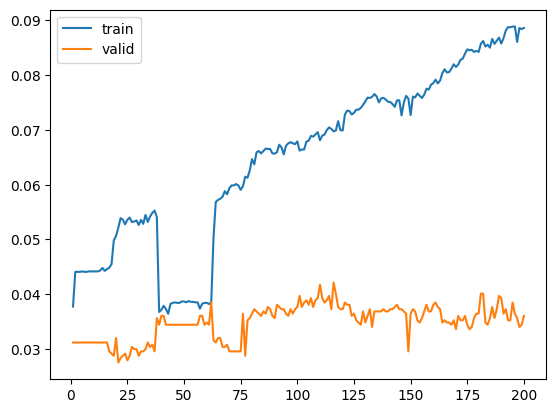

In [39]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [56]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [57]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Transformo a tensor
    tensor = torch.from_numpy(encoded.astype(np.int32))

    # Predicción softmax
    y_hat = model1(tensor).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/Users/andavaro/opt/miniconda3/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [40]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
        # Transformo a tensor
        tensor = torch.from_numpy(encoded.astype(np.int32))

        # Predicción softmax
        y_hat = model1(tensor).argmax(axis=-1)

		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [80]:
input_text='Even if you'#it makes me,would shiver the

generate_seq(model1, tok, input_text, max_length=3, n_words=1)

'Even if you is'

### 7 - Conclusiones
Se trató de entrenar el modelo con el libro "La Vuelta al Mundo en 80 Días" como corpus, pero el resultado fue un muy mal desempeño, incluso al entrenarlo con 500 épocas. Entonces, se entrenó el modelo entrenado con el dataset de bandas de habla inlesa visto en clase, pero esta vez tomando a Nirvana como referencia. El desempeño continuó siendo bastante pobre, además de presentar overfitting. Se probó con frases aleatorias del corpus y los resultados fueron fueron los siguientes:
- load up on -----> load up on you
- even if you -----> even if you is
- it makes me -----> it makes me a
- would shiver the -----> would shiver the the